In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
import tqdm
from params import *
from deform_tools import deform_to_cycle_template

%matplotlib inline

In [3]:
save = False

In [4]:
ratio = 0.3

In [5]:
frontal_spindles_only = False

In [6]:
participants = patients

In [7]:
def tf_cycle_stretch_expi(da, rsp_features, nb_point_by_cycle=1000, expi_ratio =ratio):
    # da = 3d da ('raw',freqs * time)
    da_stretch_cycle = None

    clipped_times, times_to_cycles, cycles, cycle_points, deformed_data = deform_to_cycle_template(data = da.values.T,
                                                                                                   times = da.coords['time'].values , 
                                                                                                   cycle_times=rsp_features[['start_time','transition_time']].values, 
                                                                                                   nb_point_by_cycle=nb_point_by_cycle,
                                                                                                   inspi_ratio = expi_ratio)
    deformed = deformed_data.T    

    for cycle in cycles:
        data_of_the_cycle = deformed[:,cycle*nb_point_by_cycle:(cycle+1)*nb_point_by_cycle]
        if da_stretch_cycle is None:
            da_stretch_cycle = gh.init_da({'cycle' : cycles, 'freqs': da.coords['freqs'].values , 'point':np.arange(0,nb_point_by_cycle,1)})
        da_stretch_cycle.loc[cycle, : , :] = data_of_the_cycle
        
    da_return = xr.concat([da_stretch_cycle , (da_stretch_cycle - np.mean(da_stretch_cycle.values)) / np.std(da_stretch_cycle.values)], dim = 'normalisation')
    da_return = da_return.assign_coords({'normalisation':['raw','normal']})
    new_rsp_features = rsp_features[rsp_features.index.isin(list(cycles))]
    return da_return, new_rsp_features

In [8]:
def inspi_to_expi_rsp_features(participant, rsp_features):
    spindles = pd.read_excel(f'../df_analyse/spindles_{participant}.xlsx', index_col = [0])
    if frontal_spindles_only:
        spindles = spindles[spindles['Channel'].isin(['Fp1-C3','Fp2-C4'])] # ONLY FRONTAL SPINDLES !!
    
    rows = []
    for i in rsp_features.index:
        if not i+1 in rsp_features.index: # tricks for cycles removed at detection cycle step
            continue
        if i != rsp_features.index[-1]:
            start = rsp_features.loc[i,'inspi_time']
            transition = rsp_features.loc[i, 'expi_time']
            stop = rsp_features.loc[i+1, 'inspi_time']

            start_idx = rsp_features.loc[i,'inspi_index']
            transition_idx = rsp_features.loc[i, 'expi_index']
            stop_idx = rsp_features.loc[i+1, 'inspi_index']

            participant = rsp_features.loc[i,'participant']

            expi_duration = stop - transition
            inspi_duration = transition - start
            cycle_duration = stop - start
            ratio_transition = inspi_duration / cycle_duration
            
            n_spindles_in_cycle = spindles[(spindles['Peak'] >= start) & (spindles['Peak'] < stop)].shape[0]
            if n_spindles_in_cycle == 0:
                encoding = 0
            else:
                encoding = 1
            
            if cycle_duration < 20:
                rows.append([participant, start_idx, transition_idx, stop_idx, start , transition , stop, expi_duration, inspi_duration,  cycle_duration, ratio_transition, encoding, n_spindles_in_cycle])
    df_expi_rsp_features = pd.DataFrame(rows, columns = ['participant','start_idx','transition_idx','stop_idx','start_time','transition_time','stop_time','expi_duration','inspi_duration', 'cycle_duration','ratio_transition','spindled','n_spindles'])
    return df_expi_rsp_features

In [9]:
def get_midx_stretched_da(participant, df_all_expi_features):
    da = xr.load_dataarray(f'../dataarray/da_tf_frontal_{participant}.nc')
    rsp_features_participant = df_all_expi_features[df_all_expi_features['participant'] == participant]
    print(participant, rsp_features_participant['spindled'].value_counts())
    da_stretch_cycle, new_rsp_features = tf_cycle_stretch_expi(da = da , rsp_features = rsp_features_participant)
    da_stretch_midx = gh.midx_da(da = da_stretch_cycle , dim = 'cycle', midx_labels = ('c','spindling','n_spindles'), midx_coords = [new_rsp_features.index, list(new_rsp_features.loc[:,'spindled']), list(new_rsp_features.loc[:,'n_spindles'])])
    mean_cycle_da = da_stretch_midx.groupby('spindling').mean()
    all_cycles = mean_cycle_da.mean('spindling')
    unspindled = mean_cycle_da.sel(spindling=0).drop('spindling')
    spindled = mean_cycle_da.sel(spindling=1).drop('spindling')
    diff = spindled - unspindled
    da_return = xr.concat([all_cycles, spindled, unspindled, diff], dim = 'spindle_mode').assign_coords({'spindle_mode':['all','spindled','unspindled','diff']})
    return da_return

In [10]:
concat = []
for participant in participants:
    concat.append(inspi_to_expi_rsp_features(participant,rsp_features=pd.read_excel(f'../df_analyse/resp_features_{participant}.xlsx', index_col = 0)))
df_all_expi_features = pd.concat(concat)

In [11]:
df_all_expi_features

,participant,start_idx,transition_idx,stop_idx,start_time,transition_time,stop_time,expi_duration,inspi_duration,cycle_duration,ratio_transition,spindled,n_spindles
0,P1,155,434,913,0.605469,1.695312,3.566406,1.871094,1.089844,2.960938,0.368074,0,0
1,P1,913,1202,1717,3.566406,4.695312,6.707031,2.011719,1.128906,3.140625,0.359453,0,0
2,P1,1717,1996,2520,6.707031,7.796875,9.843750,2.046875,1.089844,3.136719,0.347447,0,0
3,P1,2520,2795,3324,9.843750,10.917969,12.984375,2.066406,1.074219,3.140625,0.342040,0,0
4,P1,3324,3557,3973,12.984375,13.894531,15.519531,1.625000,0.910156,2.535156,0.359014,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,P10,3350335,3350635,3351173,13087.246094,13088.417969,13090.519531,2.101562,1.171875,3.273438,0.357995,0,0
3288,P10,3351173,3351466,3351992,13090.519531,13091.664062,13093.718750,2.054688,1.144531,3.199219,0.357753,0,0
3289,P10,3351992,3352298,3352852,13093.718750,13094.914062,13097.078125,2.164062,1.195312,3.359375,0.355814,0,0
3290,P10,3352852,3353141,3353678,13097.078125,13098.207031,13100.304688,2.097656,1.128906,3.226562,0.349879,0,0


In [12]:
df_all_expi_features.describe()

,start_idx,transition_idx,stop_idx,start_time,transition_time,stop_time,expi_duration,inspi_duration,cycle_duration,ratio_transition,spindled,n_spindles
count,3.234200e+04,3.234200e+04,3.234200e+04,32342.000000,32342.000000,32342.000000,32342.000000,32342.000000,32342.000000,32342.000000,32342.000000,32342.000000
mean,1.821354e+06,1.821713e+06,1.822347e+06,7114.664111,7116.068353,7118.543494,2.475141,1.404242,3.879383,0.364912,0.305145,0.898027
std,1.118112e+06,1.118117e+06,1.118163e+06,4367.623379,4367.644162,4367.825633,0.588994,0.318632,0.721382,0.059237,0.460476,1.733823
min,1.550000e+02,4.340000e+02,9.130000e+02,0.605469,1.695312,3.566406,0.917969,0.503906,1.847656,0.077747,0.000000,0.000000
25%,8.571388e+05,8.575072e+05,8.581170e+05,3348.198242,3349.637695,3352.019531,2.058594,1.195312,3.402344,0.335083,0.000000,0.000000
50%,1.772985e+06,1.773386e+06,1.774021e+06,6925.722656,6927.289062,6929.769531,2.394531,1.410156,3.843750,0.365432,0.000000,0.000000
75%,2.675434e+06,2.675789e+06,2.676544e+06,10450.913086,10452.300781,10455.250000,2.816406,1.562500,4.273438,0.395392,1.000000,1.000000
max,4.751070e+06,4.751515e+06,4.752196e+06,18558.867188,18560.605469,18563.265625,9.757812,8.796875,13.281250,0.838809,1.000000,17.000000


In [13]:
df_all_expi_features['n_spindles'].value_counts()

0     22473
1      2997
2      2017
3      1594
4      1212
5       919
6       570
7       324
8       137
9        40
10       29
11       16
12        8
13        5
17        1
Name: n_spindles, dtype: int64

In [14]:
concat= []
for participant in participants:
    concat.append(get_midx_stretched_da(participant, df_all_expi_features))
da_all = xr.concat(concat, dim = 'participant').assign_coords({'participant':participants})

P1 0    2588
1    1050
Name: spindled, dtype: int64
P2 0    3427
1    1170
Name: spindled, dtype: int64
P3 0    2555
1    1472
Name: spindled, dtype: int64
P4 0    2069
1    1238
Name: spindled, dtype: int64
P5 0    2228
1    1141
Name: spindled, dtype: int64
P6 0    2735
1     424
Name: spindled, dtype: int64
P7 0    2204
1    1679
Name: spindled, dtype: int64
P9 0    2393
1     677
Name: spindled, dtype: int64
P10 0    2274
1    1018
Name: spindled, dtype: int64


In [15]:
da_all = xr.concat(concat, dim = 'participant').assign_coords({'participant':participants})

In [16]:
da_all

<xarray.DataArray (participant: 9, spindle_mode: 4, normalisation: 2, freqs: 40, point: 1000)>
array([[[[[ 4.55038189e+03,  4.54178203e+03,  4.53291169e+03, ...,
            4.61087307e+03,  4.61098880e+03,  4.61088142e+03],
          [ 4.24837832e+03,  4.23898197e+03,  4.22948302e+03, ...,
            4.33933086e+03,  4.33816756e+03,  4.33675043e+03],
          [ 4.03613552e+03,  4.02650720e+03,  4.01694705e+03, ...,
            4.15365333e+03,  4.15128790e+03,  4.14865768e+03],
          ...,
          [ 3.25752669e+02,  3.25874615e+02,  3.25955704e+02, ...,
            3.45856932e+02,  3.46094963e+02,  3.46295894e+02],
          [ 3.10022545e+02,  3.10152402e+02,  3.10249639e+02, ...,
            3.29295318e+02,  3.29515734e+02,  3.29703432e+02],
          [ 2.96334476e+02,  2.96483576e+02,  2.96608095e+02, ...,
            3.14557167e+02,  3.14785942e+02,  3.14985972e+02]],

         [[ 2.34158084e-01,  2.33057168e-01,  2.31921625e-01, ...,
            2.41901897e-01,  2.41916712e-01,  2.41902967e-01],
          [ 1.95496922e-01,  1.94294042e-01,  1.93078029e-01, ...,
            2.07140263e-01,  2.06991344e-01,  2.06809929e-01],
          [ 1.68326536e-01,  1.67093962e-01,  1.65870113e-01, ...,
            1.83370647e-01,  1.83067835e-01,  1.82731126e-01],
...
          [-3.55055466e+01, -3.47225077e+01, -3.39057342e+01, ...,
           -3.52730951e+01, -3.54381436e+01, -3.53419132e+01],
          [-2.89326037e+01, -2.80710830e+01, -2.72007087e+01, ...,
           -3.00752742e+01, -3.00403929e+01, -2.97581071e+01],
          [-2.03814357e+01, -1.94857524e+01, -1.86025600e+01, ...,
           -2.26624383e+01, -2.24692644e+01, -2.20619857e+01]],

         [[ 1.28244642e-02,  1.41902995e-02,  1.53822361e-02, ...,
            1.89194336e-01,  1.89946733e-01,  1.89722453e-01],
          [ 3.83080251e-02,  3.96535240e-02,  4.08045119e-02, ...,
            2.32742604e-01,  2.33481191e-01,  2.33752277e-01],
          [ 6.70783443e-02,  6.84901092e-02,  6.97012051e-02, ...,
            2.76759089e-01,  2.77352624e-01,  2.78065536e-01],
          ...,
          [-9.30640996e-03, -9.10116653e-03, -8.88708084e-03, ...,
           -9.24548177e-03, -9.28874288e-03, -9.26351979e-03],
          [-7.58356644e-03, -7.35775202e-03, -7.12961695e-03, ...,
           -7.88307346e-03, -7.87393065e-03, -7.79994033e-03],
          [-5.34220748e-03, -5.10743863e-03, -4.87594380e-03, ...,
           -5.94008435e-03, -5.88945125e-03, -5.78269885e-03]]]]])
Coordinates:
  * freqs          (freqs) float64 10.0 10.26 10.51 10.77 ... 19.49 19.74 20.0
  * point          (point) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * normalisation  (normalisation) <U6 'raw' 'normal'
  * spindle_mode   (spindle_mode) <U10 'all' 'spindled' 'unspindled' 'diff'
  * participant    (participant) <U3 'P1' 'P2' 'P3' 'P4' ... 'P7' 'P9' 'P10'

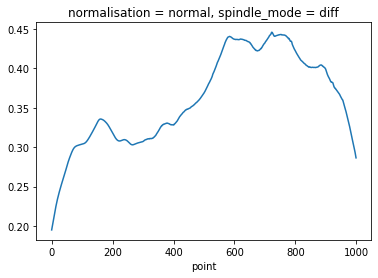

In [17]:
da_all.mean('participant').sel(normalisation = 'normal').loc['diff',11:16,:].mean('freqs').plot.line(x='point')

In [18]:
da = da_all.sel(normalisation = 'normal')

In [19]:
xvline = ratio * 1000
inspi_label_pos = xvline / 2
expi_label_pos = 1000 - ((1000-xvline)/2)

In [20]:
if frontal_spindles_only:
    save_title_append = '_frontal_spindle_only'
else:
    save_title_append = None

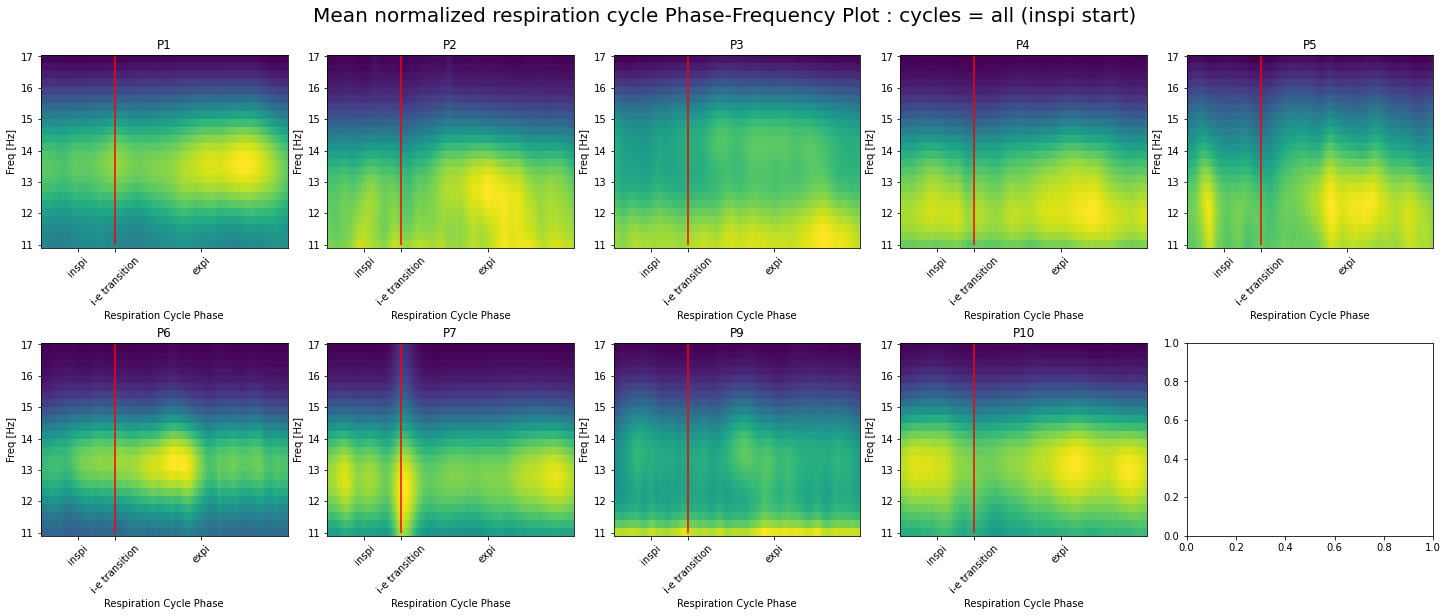

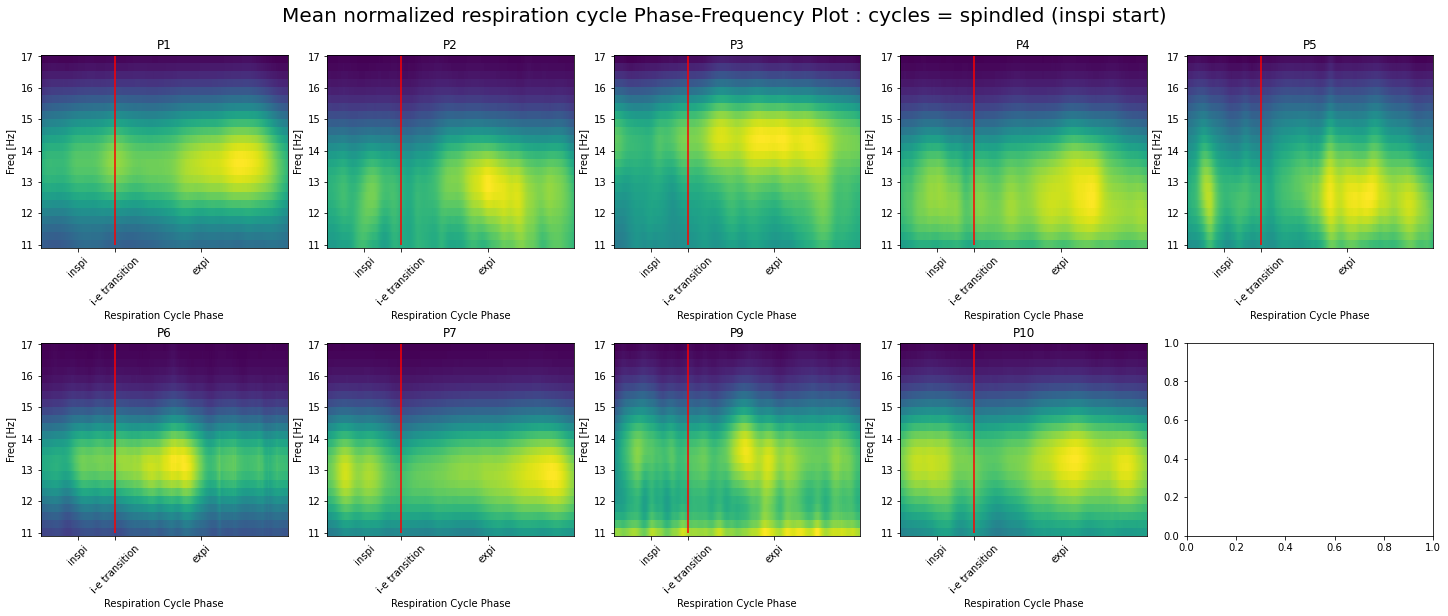

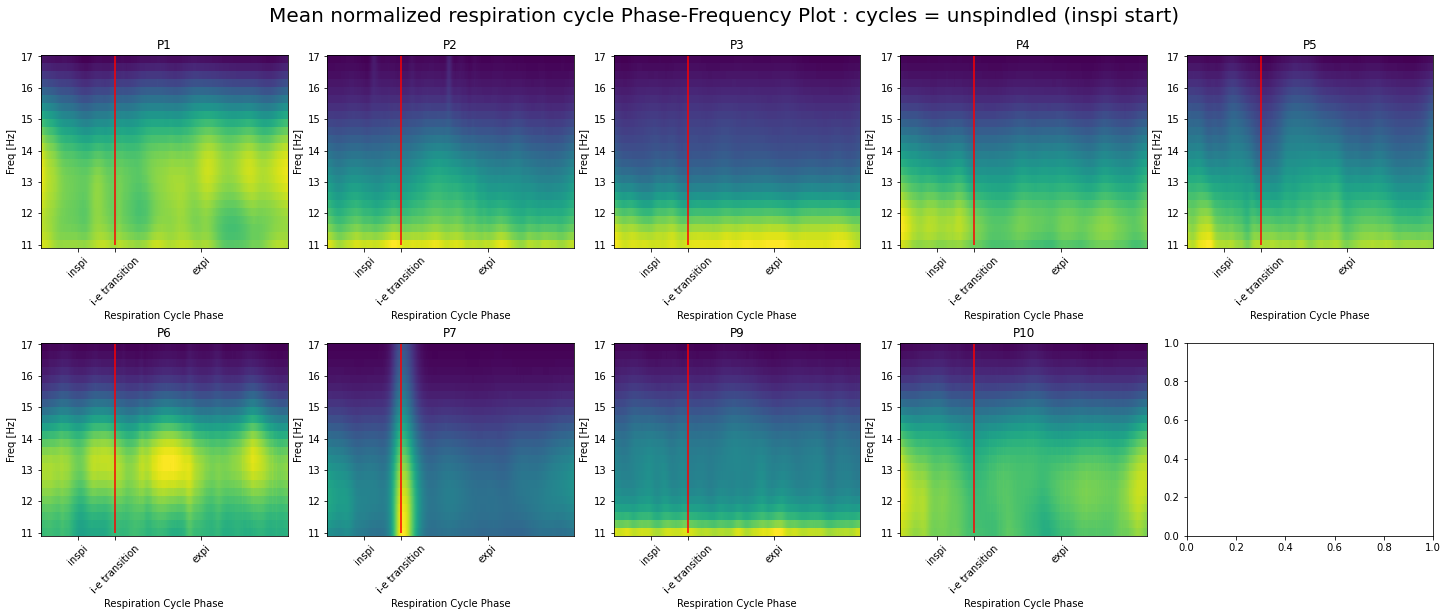

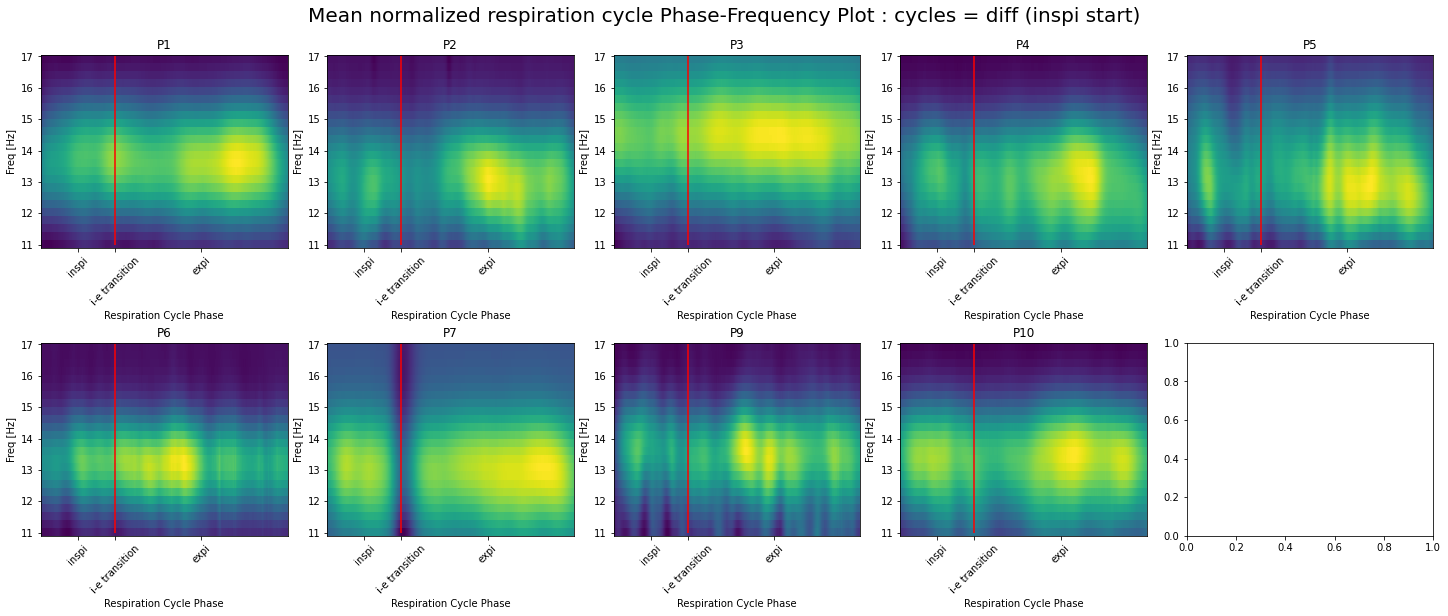

In [21]:
for mode in da.coords['spindle_mode'].values:
    fig, axs = plt.subplots(ncols = 5, nrows = 2, constrained_layout = True, figsize = (20,8))
    fig.suptitle(f'Mean normalized respiration cycle Phase-Frequency Plot : cycles = {mode} (inspi start)', fontsize = 20, y = 1.05)
    for row, sublists in enumerate([ participants[:5] , participants[5:] ]): 
        for col, participant in enumerate(sublists):
            ax = axs[row, col]
            min_freq = 11
            max_freq = 17
            data = da.loc[participant, mode , min_freq:max_freq,:].values
            ax.pcolormesh(da.coords['point'], da.coords['freqs'].loc[min_freq:max_freq], data)
            ax.set_title(participant)
            ax.set_ylabel('Freq [Hz]')
            ax.set_xlabel('Respiration Cycle Phase')
            ax.vlines(x = xvline, ymin = min_freq, ymax=max_freq, color = 'r')
            ax.set_xticks([inspi_label_pos,xvline,expi_label_pos])
            ax.set_xticklabels(['inspi','i-e transition','expi'], rotation=45, fontsize=10)
    if save:
        plt.savefig(f'../presentation_4/stretch_tf_by_participant_{mode}_inspi_start{save_title_append}', bbox_inches = 'tight')
    plt.show()

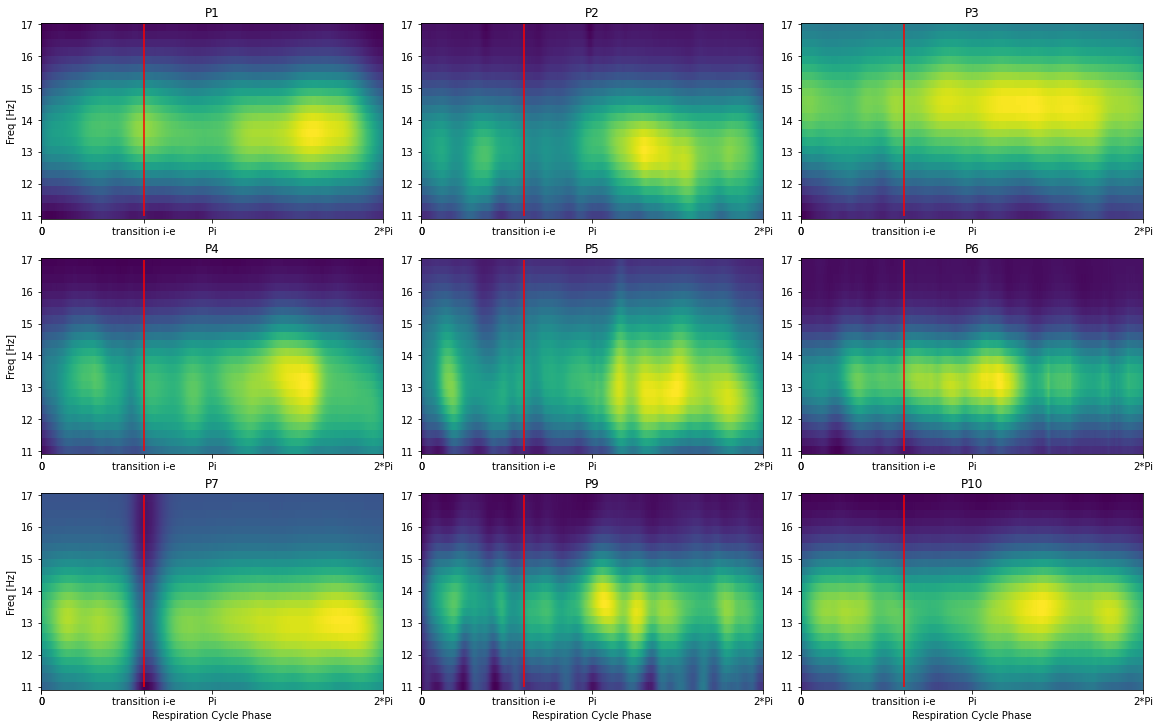

In [29]:
fig, axs = plt.subplots(ncols = 3, nrows = 3, constrained_layout = True, figsize = (16,10))
# fig.suptitle(f'Mean normalized respiration cycle Phase-Frequency Plot : cycles = {mode} (inspi start)', fontsize = 20, y = 1.05)
for row, sublists in enumerate([ participants[:3] , participants[3:6], participants[6:] ]): 
    for col, participant in enumerate(sublists):
        ax = axs[row, col]
        min_freq = 11
        max_freq = 17
        data = da.loc[participant, 'diff' , min_freq:max_freq,:].values
        ax.pcolormesh(da.coords['point'], da.coords['freqs'].loc[min_freq:max_freq], data)
        ax.set_title(participant)
        if participant in ['P1','P4','P7']:
            ax.set_ylabel('Freq [Hz]')
        if participant in ['P7','P9','P10']:
            ax.set_xlabel('Respiration Cycle Phase')
        ax.vlines(x = xvline, ymin = min_freq, ymax=max_freq, color = 'r')
        # ax.set_xticks([inspi_label_pos,xvline,expi_label_pos])
        # ax.set_xticklabels(['inspi','i-e transition','expi'], rotation=45, fontsize=10)
        ax.set_xticks([0, 0, 300, 500, 1000])
        ax.set_xticklabels([0, 0, 'transition i-e', 'Pi', '2*Pi'], rotation=0, fontsize=10)
# fig.delaxes(axs[1,4])
if mode == 'diff':
    if save:
        plt.savefig(f'../article/stretch_tf_by_participant_{mode}', bbox_inches = 'tight')
plt.show()

In [ ]:
fig, axs = plt.subplots(ncols = 4, constrained_layout = True, figsize = (20,5))
fig.suptitle('Mean participant * respiration cycles normalized Phase-Frequency Plot (inspi start)', fontsize = 20, y = 1.05)
min_freq = 11
max_freq = 16

for col, mode in enumerate(da.coords['spindle_mode'].values):
    ax = axs[col]
    data = da.loc[:, mode , min_freq:max_freq,:].mean('participant').values
    ax.pcolormesh( da.coords['point'] , da.coords['freqs'].loc[min_freq:max_freq] , data)
    ax.set_title(mode)
    ax.set_ylabel('Freq [Hz]')
    ax.set_xlabel('Respiration Cycle Phase')
    ax.vlines(x = xvline, ymin = min_freq, ymax=max_freq, color = 'r')
    ax.set_xticks([inspi_label_pos,xvline,expi_label_pos])
    ax.set_xticklabels(['inspi','i-e transition','expi'], rotation=45, fontsize=10)
if save:
    plt.savefig(f'../presentation_5/stretch_tf_mean_participant_modes_inspi_start', bbox_inches = 'tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout = True, figsize = (10,5))
min_freq = 11
max_freq = 16

data = da.loc[:, 'diff' , min_freq:max_freq,:].mean('participant').values
ax.pcolormesh( da.coords['point'] , da.coords['freqs'].loc[min_freq:max_freq] , data)
ax.set_ylabel('Freq [Hz]')
ax.set_xlabel('Respiration Cycle Phase')
ax.vlines(x = xvline, ymin = min_freq, ymax=max_freq, color = 'r')
ax.set_xticks([0, 0, 300, 500, 1000])
ax.set_xticklabels([0, 0, 'transition inspi-expi', 'Pi', '2*Pi'], rotation=0, fontsize=10)

if save:
    plt.savefig(f'../article/stretch_tf_mean_participant', bbox_inches = 'tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout = True, figsize = (10,7))
min_freq = 12
max_freq = 13
data = da.loc[:, 'diff' , min_freq:max_freq,:].mean(['participant','freqs']).values
ax.plot(da.coords['point'], data)
ax.set_title('Mean participant * Spindled respiration cycles normalized Sigma Power')
ax.set_ylabel('Sigma Power')
ax.set_xlabel('Respiration Cycle Phase')
ax.vlines(x = xvline, ymin = min(data), ymax=max(data), color = 'r')
ax.set_xticks([inspi_label_pos,xvline,expi_label_pos])
ax.set_xticklabels(['inspi','i-e transition','expi'], rotation=45, fontsize=10)
if save:
    plt.savefig(f'../presentation_4/stretch_sigma_power_mean_participant_inspi_start{save_title_append}', bbox_inches = 'tight')
plt.show()